## Reference:
* https://scikit-learn.org/stable/supervised_learning.html

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import math
from sklearn import preprocessing

In [2]:
sns.set()

In [3]:
#https://finance.yahoo.com/
start = datetime(2014,1, 1)
end = datetime.now()
stocks = 'LINX3.SA';

df = web.DataReader([stocks],'yahoo',start=start,end=end)  
df.tail()

Attributes,High,Low,Open,Close,Volume,Adj Close
Symbols,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA
Date,,,,,,
2019-08-29,30.250000,29.020000,29.410000,30.000000,987700.0,30.000000
2019-08-30,32.840000,30.799999,30.830000,31.879999,2232200.0,31.879999
2019-09-02,32.080002,31.070000,31.900000,31.700001,737900.0,31.700001
2019-09-03,31.980000,30.840000,31.709999,31.000000,1139300.0,31.000000
2019-09-04,31.370001,30.170000,31.370001,30.170000,1939300.0,30.170000


In [4]:
days = 20
df['prediction'] = df['Close'].shift(days)
df.dropna(inplace=True)

In [5]:
df.tail()

Attributes,High,Low,Open,Close,Volume,Adj Close,prediction
Symbols,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA,LINX3.SA,
Date,,,,,,,
2019-08-29,30.250000,29.020000,29.410000,30.000000,987700.0,30.000000,32.520000
2019-08-30,32.840000,30.799999,30.830000,31.879999,2232200.0,31.879999,31.950001
2019-09-02,32.080002,31.070000,31.900000,31.700001,737900.0,31.700001,31.270000
2019-09-03,31.980000,30.840000,31.709999,31.000000,1139300.0,31.000000,31.900000
2019-09-04,31.370001,30.170000,31.370001,30.170000,1939300.0,30.170000,31.950001


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
forecast_time = int(days)

X = np.array(df.drop(['prediction'], 1))
Y = np.array(df['prediction'])
Y = Y[:-forecast_time]
X = X[:-forecast_time]


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

In [8]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_train_fit = lab_enc.fit_transform(y_train)
y_test_fit = lab_enc.fit_transform(y_test)

In [9]:
x_forecast = np.array(df.drop(['prediction'],1))[-forecast_time:]

In [10]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn import linear_model
regressor = linear_model.LinearRegression()  
regressor.fit(x_train, y_train)

regressor_score = round(regressor.score(x_test, y_test) * 100, 2)
print("Linear Regressor Score - > ", regressor_score)
regressor_predictions = regressor.predict(x_forecast)

Linear Regressor Score - >  85.29


In [11]:
lasso = linear_model.Lasso(alpha=0.5, max_iter=2000)
lasso.fit(x_train, y_train)

lasso_score = round(lasso.score(x_test, y_test) * 100, 2)
print("Lasso - > ", lasso_score)

lasso_predictions = lasso.predict(x_forecast)

Lasso - >  85.0


In [12]:
ridge = linear_model.Ridge(alpha=25.5, max_iter=2000)
ridge.fit(x_train, y_train)

ridge_score = round(ridge.score(x_test, y_test) * 100, 2)
print("Linear Ridge - > ", ridge_score)

ridge_predictions = ridge.predict(x_forecast)

Linear Ridge - >  85.45


In [13]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Lasso', 'Ridge'],
    'Score': [regressor_score, lasso_score, ridge_score]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Ridge,85.45
0,Linear Regression,85.29
1,Lasso,85.00


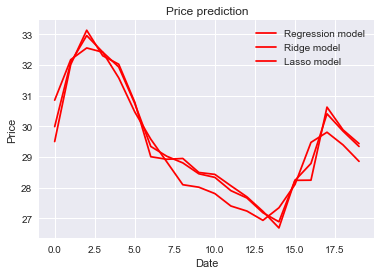

In [14]:
days_array = np.arange(days)
plt.plot(days_array, regressor_predictions, color='red', label = 'Regression model')
plt.plot(days_array, ridge_predictions, color='red', label = 'Ridge model')
plt.plot(days_array, lasso_predictions, color='red', label = 'Lasso model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price prediction')
plt.legend()